## Skipgrams in Keras

- In this lecture, we will implement Skipgrams in `Keras`.

#### Loading in and preprocessing data
- Load the Alice in Wonderland data in Corpus using Keras utility
- `Keras` has some nice text preprocessing features too!
- Split the text into sentences.
- Use `Keras`' `Tokenizer` to tokenize sentences into words.

In [1]:
# Imports
# Basics
from __future__ import print_function, division
import pandas as pd 
import numpy as np
import random
from IPython.display import SVG
%matplotlib inline

# nltk
from nltk import sent_tokenize

# keras
np.random.seed(13)
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Activation
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot 
from keras.preprocessing.sequence import skipgrams

Using TensorFlow backend.


In [2]:
# We'll use Alice in Wonderland

path = get_file('carrol-alice.txt', origin="http://www.gutenberg.org/files/11/11-0.txt")
corpus = open(path).read()

In [3]:
# Split document into sentences first
corpus = corpus[corpus.index('\n\n')+2:]  # remove header.
sentences = sent_tokenize(corpus)

# Tokenize using Keras
base_filter='!"#$%&()*+,-./:;`<=>?@[\\]^_{|}~\t\n' + "'"
tokenizer = Tokenizer(filters=base_filter)
tokenizer.fit_on_texts(sentences)

# Convert tokenized sentences to sequence format
sequences = tokenizer.texts_to_sequences(sentences)
nb_samples = sum(len(s) for s in corpus)

print(len(sequences), tokenizer.document_count)

1093 1093


In [4]:
# To understand what is happening;

print(sentences[324])  # this is a sentence
print(sequences[324])  # this is the same sentence where words are encoded as numbers.
print(list(tokenizer.word_index[word.lower().replace('.', '')] 
           for word in sentences[324].split()))

The Caterpillar was the first to speak.
[1, 182, 13, 1, 98, 4, 330]
[1, 182, 13, 1, 98, 4, 330]


#### Skipgrams: Generating Input and Output Labels
- Now that we have sentences, and word tokenization, we are in good position to create our training set for skipgrams.
- Now we need to generate our `X_train` and `y_train`

In [5]:
# Let's first see how Keras' skipgrams function works.

couples, labels = skipgrams(sequences[324], len(tokenizer.word_index) + 1,
    window_size=2, negative_samples=0, shuffle=True,
    categorical=False, sampling_table=None)

index_2_word = {val: key for key, val in tokenizer.word_index.items()}

for w1, w2 in couples:
    if w1 == 13:
        print(index_2_word[w1], index_2_word[w2])

was the
was caterpillar
was the
was first


In [13]:
# Function to generate the inputs and outputs for all windows

# Vocab size
vocab_size = len(tokenizer.word_index) + 1
# Dimension to reduce to
dim = 100
window_size = 2


def generate_data(sequences, window_size, vocab_size):
    for seq in sequences:
        X, y = [], []
        couples, _ = skipgrams(
            seq, vocab_size,
            window_size=window_size, negative_samples=0, shuffle=True,
            categorical=False, sampling_table=None)
        if not couples:
            continue
        for in_word, out_word in couples:
            X.append(in_word)
            y.append(np_utils.to_categorical(out_word, vocab_size))
        X, y = np.array(X), np.array(y)
        X = X.reshape(len(X), 1)
        y = y.reshape(len(X), vocab_size)
        yield X, y
        
data_generator = generate_data(sequences, window_size, vocab_size)

### Skipgrams: Creating the Model
- Lastly, we create the (shallow) network!

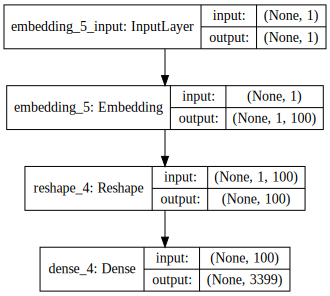

In [65]:
# Create the Keras model and view it 
skipgram = Sequential()
skipgram.add(Embedding(input_dim=vocab_size, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim,)))
skipgram.add(Dense(input_dim=dim, units=vocab_size, activation='softmax'))
SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg'))

### Skipgrams: Compiling and Training
- Time to compile and train
- We use crossentropy, common loss for classification

In [66]:
# Compile the Keras Model
from keras.optimizers import SGD
sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9)

skipgram.compile(loss='categorical_crossentropy', optimizer="adadelta")

# Fit the Skipgrams
for iteration in range(10):
    loss = 0
    for x, y in generate_data(sequences, window_size, vocab_size):
        loss += skipgram.train_on_batch(x, y)
    print('iteration {}, loss is {}'.format(iteration, loss))

iteration 0, loss is 8692.849100112915
iteration 1, loss is 8322.35824584961
iteration 2, loss is 7910.393621921539
iteration 3, loss is 7639.745084762573
iteration 4, loss is 7453.300776958466
iteration 5, loss is 7313.637895584106
iteration 6, loss is 7205.049055099487
iteration 7, loss is 7120.1035804748535
iteration 8, loss is 7053.224799156189
iteration 9, loss is 6999.508542060852


### Skipgrams: Looking at the vectors

To get word_vectors now, we look at the weights of the first layer.

Let's also write functions giving us similarity of two words.

In [79]:
word_vectors = skipgram.get_weights()[0]


from scipy.spatial.distance import cosine


def get_dist(w1, w2):
    i1, i2 = tokenizer.word_index[w1], tokenizer.word_index[w2]
    v1, v2 = word_vectors[i1], word_vectors[i2]
    return cosine(v1, v2)

def get_similarity(w1, w2):
    return 1-get_dist(w1, w2)

def get_most_similar(w1, n=10):
    sims = {word: get_similarity(w1, word) 
            for word in tokenizer.word_index.keys()
            if word != w1}
    sims = pd.Series(sims)
    sims.sort_values(inplace=True, ascending=False)
    return sims.iloc[:n]


print(get_similarity('king', 'queen'))
print('')
print(get_most_similar('queen'))

0.972093939216

queen      1.000000
king       0.972094
hatter     0.971857
gryphon    0.967817
mock       0.964034
white      0.960492
rabbit     0.960487
by         0.959807
duchess    0.959013
march      0.958182
dtype: float64


/Users/taylanbilal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## Your turn -- Modify the code above to create a CBOW Model